##  `Steane code - a Quantum Error-correcting code`  

In this notebook we will construct a function that takes two imputs: $x\in \mathbb{F}^n_2$ and an error probability $p\in(0,1)$ and outputs the logical state $\ket{x_L}$ in Steane's code. 
We will then run it thuoght a Pauli Error Channel, with error rate $p$, measures syndromes, applies the recovery operation when needed, measure the data qubits and decodes the results.

Recall that Steane's code is a 7 qubits code to encode 1 logical qubit, it can correct any single-qubit error $(X,Y,Z)$. It has distance 3 which means that it can detect up to two erros and correct one. It is insipired from the CCS $[7,4,3]$ Hamming code. It is constructed from two classical linear coodes, one for correcting bit-flip errors and one for correcting phase-flip errors.

We will proceed as follows, first the Encoding steps:
   - The logical qubit is encoded into **7 physical qubits** using combinations of codewords from the classical **[7,4,3] Hamming code**.
   - This encoding spreads the information across multiple qubits, enabling protection against single-qubit errors.

Next the Error correction:

- **Syndrome measurement:** Separate syndromes are measured to detect **bit-flip (X)** and **phase-flip (Z)** errors.  
- These measurements are performed using stabilizer operators derived from the classical code's **parity check matrix**.
- **Error identification and correction:** The measured syndrome indicates the location and type of error, allowing it to be corrected by applying the appropriate **Pauli operator** (X, Y, or Z).

For the construction we will follow https://errorcorrectionzoo.org/c/steane

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

H = np.array([
    [0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1]])

print("H matrix:")
print(H)

H matrix:
[[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]


The above matrix is teh parity check matric of the [7,4,3] Hamming code, the stabilizer group of Steane code has six generator, three of X-type and three of Z-type. First we will prepare the $0$ logical state using hadamard gate as well as CNOT gates matched with H. 

The next encoder is also taken from [the website](https://errorcorrectionzoo.org/c/steane)

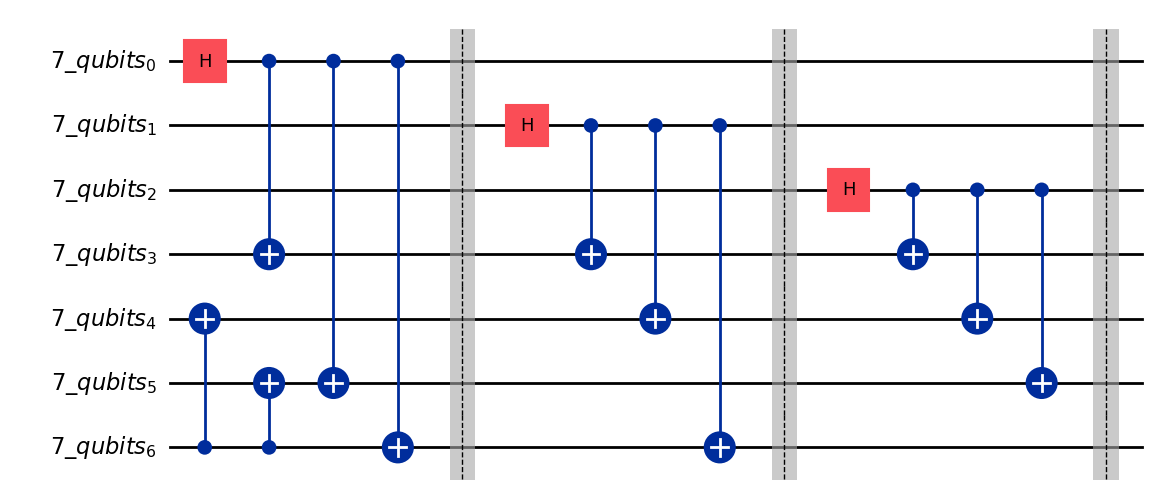

In [2]:


def steane_encoding_circuit():
    """
    Creates the Steane code encoding circuit and its inverse (decoding circuit).
    
    Returns:
        encoding (QuantumCircuit): the Steane encoding circuit.
        decoding (QuantumCircuit): the inverse of the encoding circuit (decoding).
    """
    sevenqubits = QuantumRegister(7, name="7_qubits")
    encoding = QuantumCircuit(sevenqubits, name="Steane_encoding")
    
    # Encoding operations
    encoding.h(0)
    encoding.cx(sevenqubits[6], sevenqubits[4])
    encoding.cx(sevenqubits[6], sevenqubits[5])
    encoding.cx(sevenqubits[0], sevenqubits[3])
    encoding.cx(sevenqubits[0], sevenqubits[5])
    encoding.cx(sevenqubits[0], sevenqubits[6])
    encoding.barrier()
    
    encoding.h(1)
    encoding.cx(sevenqubits[1], sevenqubits[3])
    encoding.cx(sevenqubits[1], sevenqubits[4])
    encoding.cx(sevenqubits[1], sevenqubits[6])
    encoding.barrier()
    
    encoding.h(2)
    encoding.cx(sevenqubits[2], sevenqubits[3])
    encoding.cx(sevenqubits[2], sevenqubits[4])
    encoding.cx(sevenqubits[2], sevenqubits[5])
    encoding.barrier()
    
    # Create decoding circuit as inverse of encoding
    decoding = encoding.inverse()
    
    return encoding, decoding

# Example usage
encoding_circuit, decoding_circuit = steane_encoding_circuit()
encoding_circuit.draw('mpl')

Now we want to introduce Pauli Error in the following way:
  - `p`: the total probability of introducing any Pauli error.
It works with these 3 steps:
  1. Randomly selects one qubit out of the 7 code qubits.
  2. Generates a random number to determine if an error occurs.
  3. If an error occurs (with probability `p`), it applies **either X, Y, or Z error**, each with equal chance.

In [3]:
def Pauli_error(p):
    code_qubits = QuantumRegister(7, name="code")
    circuit = QuantumCircuit(code_qubits, name="Pauli_error")
    
    qubit_index = np.random.randint(7)  # randomly choose one qubit
    random_value = np.random.uniform(0,1)  # random number in [0,1)
    
    if random_value < p:
        # Choose a random Pauli error equally among X, Y, Z
        error_type = np.random.choice(['X', 'Y', 'Z'])
        if error_type == 'X':
            circuit.x(qubit_index)
        elif error_type == 'Y':
            circuit.y(qubit_index)
        else:
            circuit.z(qubit_index)
    
    return circuit

Now we get to the key parts of the correcting code: The `steane_check()` function constructs the **syndrome measurement circuit** for the Steane code, implementing both X-checks and Z-checks to detect errors:
We need:
  - `code_qubits`: the 7 physical qubits of the Steane code.
  - `X_check`: 3 ancilla qubits used for measuring bit-flip (X) error syndromes.
  - `Z_check`: 3 ancilla qubits used for measuring phase-flip (Z) error syndromes.

It works in the following way
  1. Defines the **parity check matrix H** of the [7,4,3] Hamming code, which determines stabilizer generators for the Steane code.
  2. For each row of H (each stabilizer):
     - Prepares the Z-check ancilla qubit in the |+⟩ state with a Hadamard gate.
     - Applies CNOTs for:
       - **X-checks:** control = code qubit, target = X-check ancilla.
       - **Z-checks:** control = Z-check ancilla, target = code qubit.
     - Applies a final Hadamard to the Z-check ancilla to complete the measurement.

This circuit is used to **detect bit-flip and phase-flip errors** by measuring the corresponding syndromes without collapsing the encoded logical information.

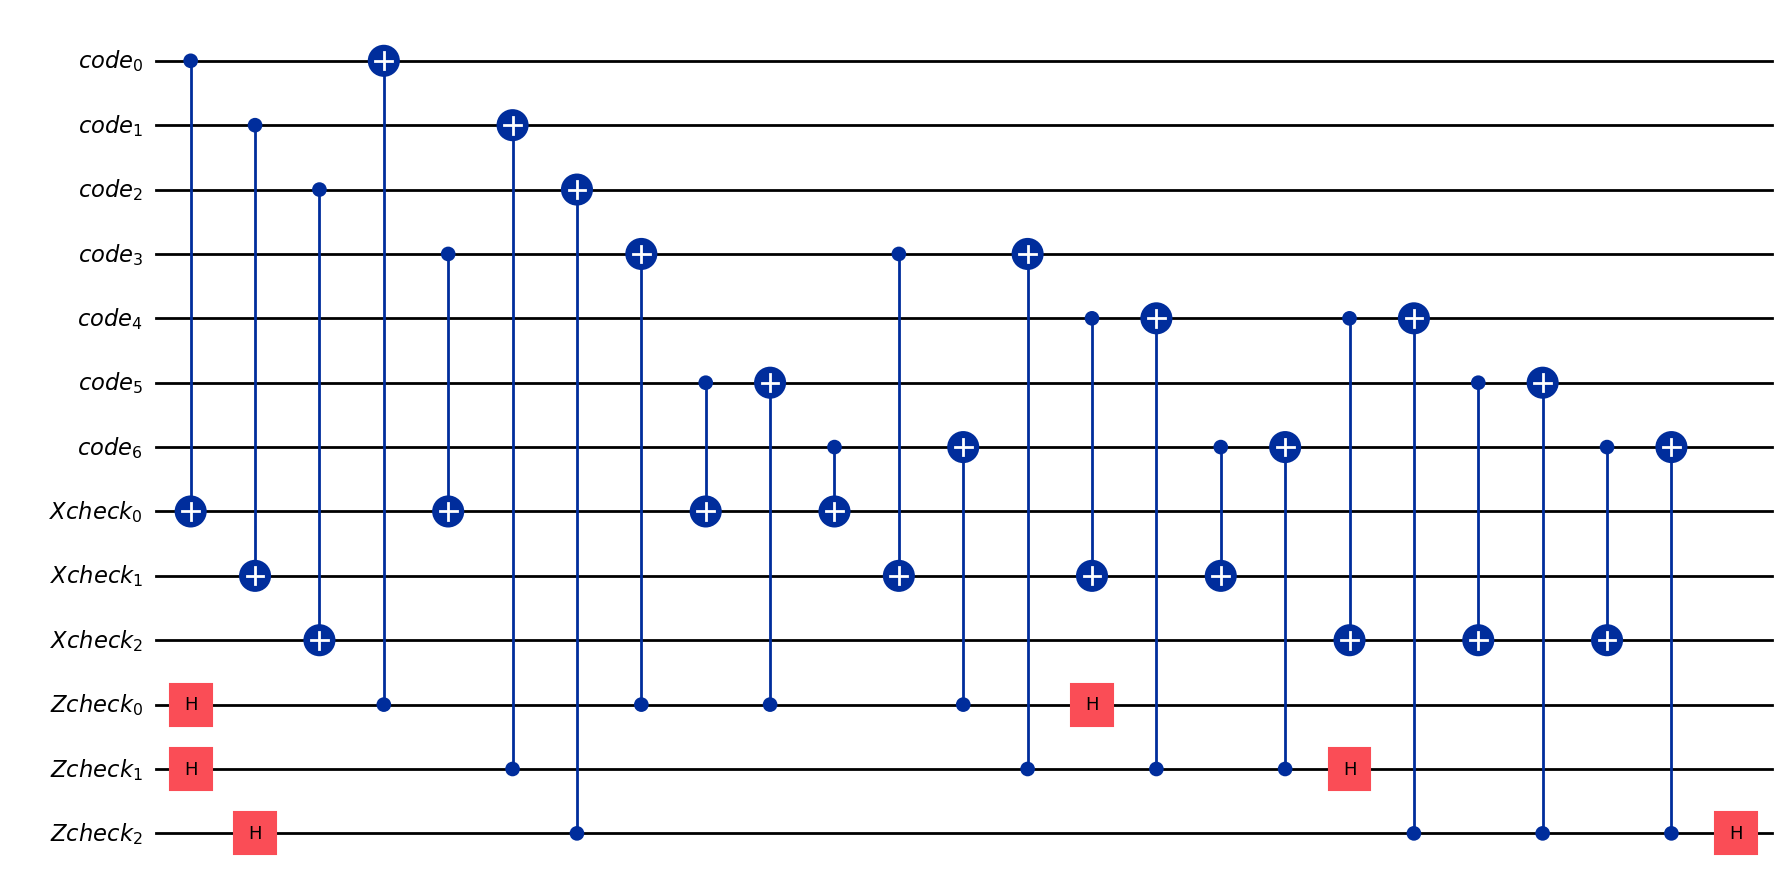

In [4]:
def steane_check():
    """
    Constructs the Steane code syndrome measurement circuit,
    performing both X-checks and Z-checks using the parity check matrix H.
    
    Returns:
        circ (QuantumCircuit): the full check circuit.
    """
    # Define code and ancilla registers
    code_qubits = QuantumRegister(7, name="code")
    X_check = AncillaRegister(3, name="Xcheck")
    Z_check = AncillaRegister(3, name="Zcheck")
    
    # Initialize circuit
    circ = QuantumCircuit(code_qubits, X_check, Z_check, name="steane_check")
    
    # Define parity check matrix H for the [7,4,3] Hamming code
    H = np.array([[1, 0, 0, 1, 0, 1, 1],
                  [0, 1, 0, 1, 1, 0, 1],
                  [0, 0, 1, 0, 1, 1, 1]])
    
    # Loop over each row of H to perform syndrome extraction
    for idx, row in enumerate(H):
        # Prepare Z check ancilla in |+> state
        circ.h(Z_check[idx])
        
        for qubit in np.where(row)[0]:
            # X check: control is code qubit, target is X_check ancilla
            circ.cx(code_qubits[qubit], X_check[idx])
            # Z check: control is Z_check ancilla, target is code qubit
            circ.cx(Z_check[idx], code_qubits[qubit])
        
        # Final Hadamard to complete Z check measurement
        circ.h(Z_check[idx])
    
    return circ

# Example usage
check_circuit = steane_check()
check_circuit.draw(output="mpl")

The `steane_syndrome()` function constructs the **syndrome measurement circuit** for the Steane code:

It uses:
  - `X_check`: Ancilla register (3 qubits) used for X-check stabilizer measurements (detecting bit-flip errors).
  - `Z_check`: Ancilla register (3 qubits) used for Z-check stabilizer measurements (detecting phase-flip errors).
  - `X_syndrome`: Classical register to store measurement results of `X_check` qubits.
  - `Z_syndrome`: Classical register to store measurement results of `Z_check` qubits.

And this is how it works:
  1. Defines the ancilla quantum registers for X and Z checks.
  2. Defines classical registers to hold the syndrome results after measurement.
  3. Measures the X-check ancillas into the `X_syndrome` classical register.
  4. Measures the Z-check ancillas into the `Z_syndrome` classical register.

This circuit is used after applying the Steane code check operations to **record the syndrome outcomes**, which will be used to **identify and correct any detected errors** in the code qubits.

In [5]:
def steane_syndrome():
    """
    Constructs the syndrome measurement circuit for the Steane code.
    Measures the X-check and Z-check ancilla qubits into classical registers.
    
    Returns:
        circ (QuantumCircuit): the syndrome measurement circuit.
    """
    # Define ancilla registers for X and Z checks
    X_check = AncillaRegister(3, name="Xcheck")
    Z_check = AncillaRegister(3, name="Zcheck")
    
    # Define classical registers to store syndrome measurement results
    X_syndrome = ClassicalRegister(3, name="Xsyndrome")
    Z_syndrome = ClassicalRegister(3, name="Zsyndrome")
    
    # Initialize circuit
    circ = QuantumCircuit(X_check, Z_check, X_syndrome, Z_syndrome, name="steane_syndrome")
    
    # Measure ancilla qubits into classical syndrome registers
    circ.measure(X_check, X_syndrome)
    circ.measure(Z_check, Z_syndrome)
    
    return circ

# Example usage
#syndrome_circuit = steane_syndrome()
#syndrome_circuit.draw(output="mpl")

Now we will define the actualy fix: `steane_fix()` function that constructs the **error correction circuit** for the Steane code:

WHat it needs:
  - `code_reg`: Quantum register containing the 7 code qubits.
  - `x_syndrome_reg`: Classical register storing the X-syndrome measurement results (bit-flip errors).
  - `z_syndrome_reg`: Classical register storing the Z-syndrome measurement results (phase-flip errors).

How does it work
  1. Defines the **syndrome-to-qubit mapping** (`syndrome_to_qubit`) used to identify which qubit needs correction based on syndrome values.
  2. For each code qubit:
     - Applies an X correction if the `x_syndrome_reg` matches its syndrome value.
     - Applies a Z correction if the `z_syndrome_reg` matches its syndrome value.

This function uses Qiskit's `.c_if()` method to conditionally apply corrections based on the measured syndrome outcomes, enabling **automatic error correction** in the Steane code decoding process.

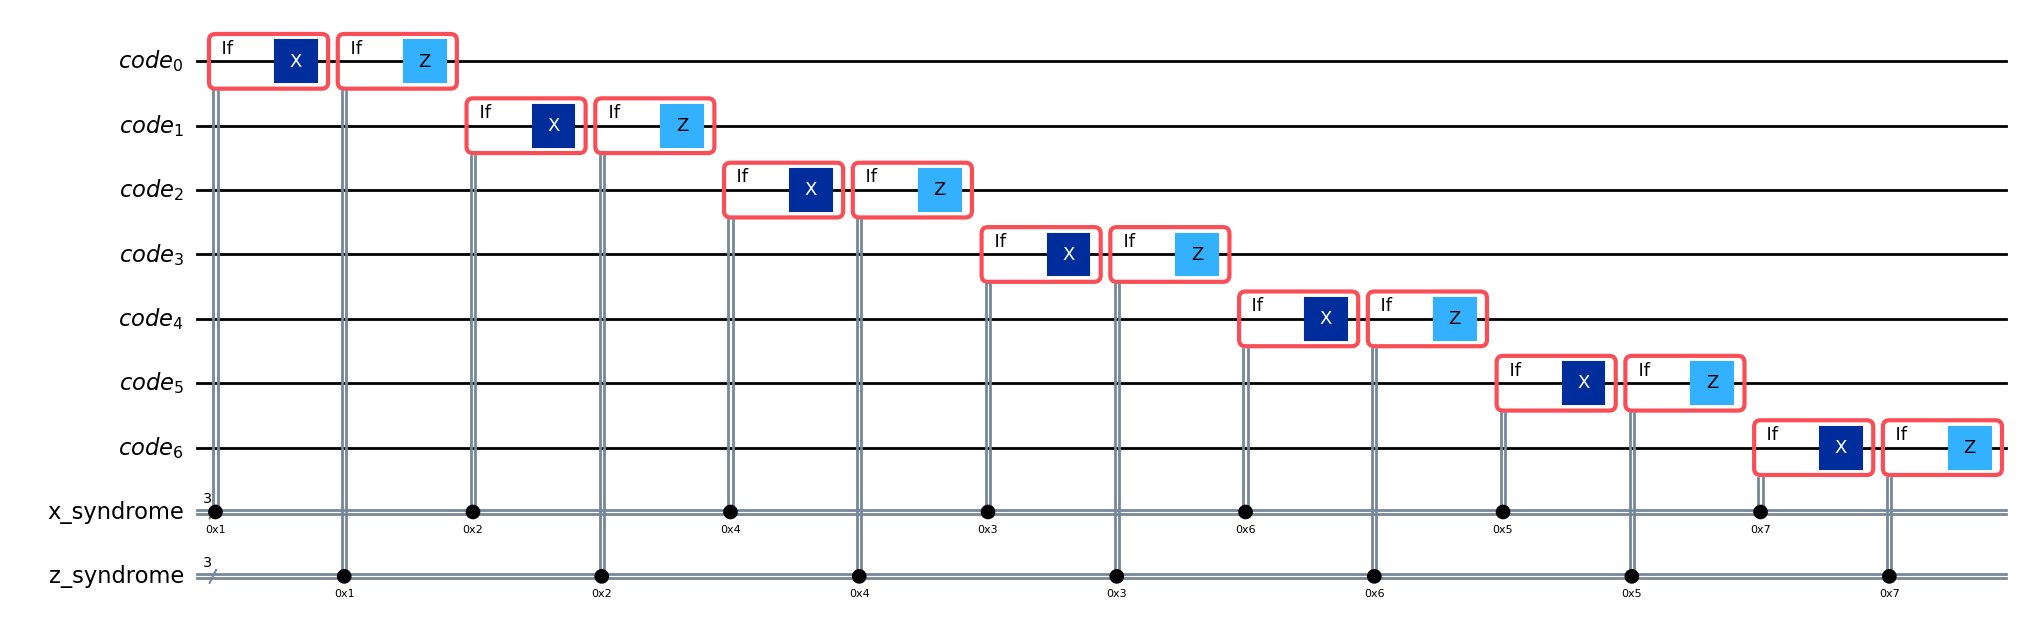

In [6]:
def steane_fix():
    """
    Constructs the Steane code correction circuit.
    Applies X and Z corrections based on measured syndrome outcomes.
    
    Returns:
        fix_circuit (QuantumCircuit): the correction circuit.
    """
    # Define code qubit register
    code_reg = QuantumRegister(7, name="code")
    
    # Define classical registers for X and Z syndromes
    x_syndrome_reg = ClassicalRegister(3, name="x_syndrome")
    z_syndrome_reg = ClassicalRegister(3, name="z_syndrome")
    
    # Initialize circuit
    fix_circuit = QuantumCircuit(code_reg, x_syndrome_reg, z_syndrome_reg, name="steane_fix")
    
    # Syndrome-to-qubit mapping based on checklist
    syndrome_to_qubit = [1, 2, 4, 3, 6, 5, 7]
    
    # Apply corrections based on syndrome measurements
    for qubit_idx in range(7):
        syndrome_value = syndrome_to_qubit[qubit_idx]
        
        # Apply X correction if x_syndrome equals syndrome_value
        with fix_circuit.if_test((x_syndrome_reg, syndrome_value)):
            fix_circuit.x(code_reg[qubit_idx])
        
        # Apply Z correction if z_syndrome equals syndrome_value
        with fix_circuit.if_test((z_syndrome_reg, syndrome_value)):
            fix_circuit.z(code_reg[qubit_idx])
    
    return fix_circuit

# Example usage
correction_circuit = steane_fix()
correction_circuit.draw(output="mpl", fold=50)

Now we can get everything together given `p`: the total probability of introducing any Pauli error.

What the steps are:
  1. **Encoding:** Encodes a logical qubit into 7 physical qubits using the Steane code.
  2. **Pauli error:** Introduces a random single-qubit Pauli error (X, Y, or Z) with probability `p`.
  3. **Check:** Measures the stabilizer generators to extract the error syndrome.
  4. **Syndrome measurement:** Records the syndrome outcomes into classical registers.
  5. **Fix (correction):** Applies X and Z corrections based on the measured syndromes.
  6. **Decoding:** Applies the inverse of the encoding circuit to return to the logical qubit state.


This function allows you to **simulate the entire Steane code process**

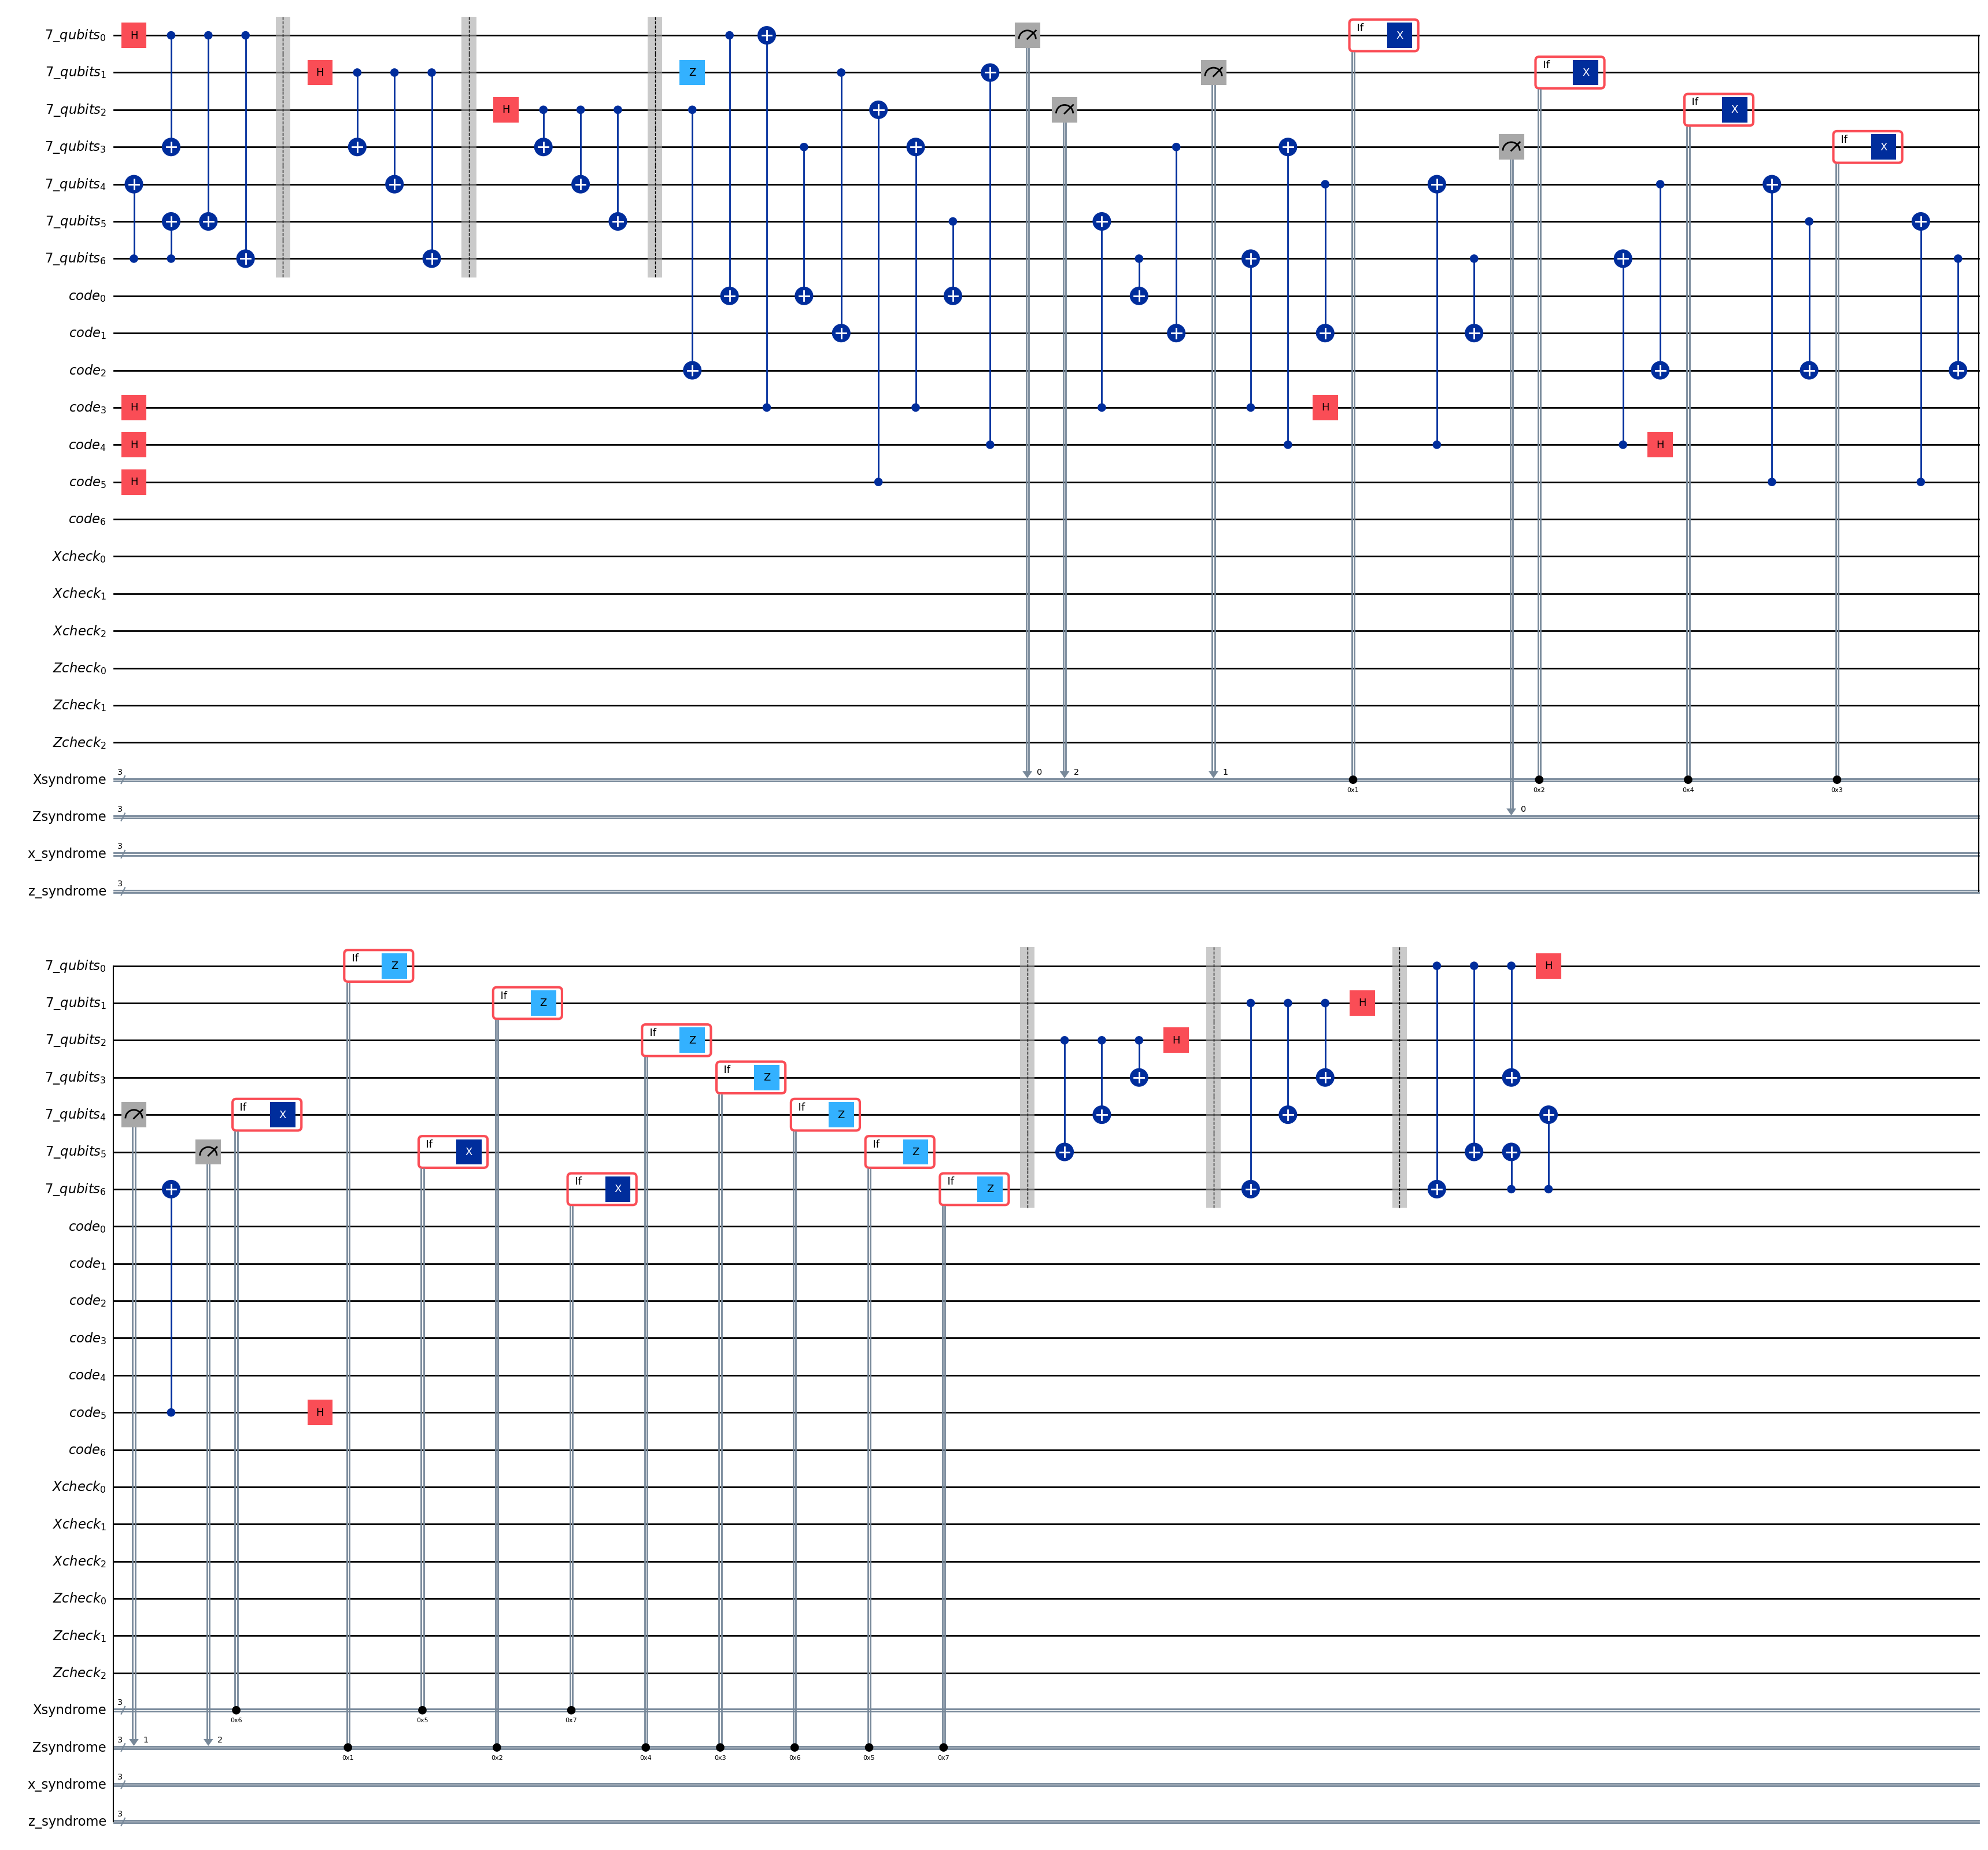

In [7]:
def steane_full_pipeline(p):
    """
    Constructs the full Steane code pipeline:
    encoding -> Pauli error -> check -> syndrome measurement -> fix -> decoding
    
    Parameters:
        p (float): total probability of introducing any Pauli error.
    
    Returns:
        full_circuit (QuantumCircuit): the complete Steane code error correction circuit.
    """
    # Encoding and decoding circuits
    encoding_circ, decoding_circ = steane_encoding_circuit()
    
    # Pauli error circuit
    pauli_error_circ = Pauli_error(p)
    
    # Check circuit (syndrome extraction)
    check_circ = steane_check()
    
    # Syndrome measurement circuit
    syndrome_circ = steane_syndrome()
    
    # Fix circuit (correction)
    fix_circ = steane_fix()
    
    # Initialize full circuit
    full_circuit = QuantumCircuit()
    
    # Collect all unique registers from all component circuits
    all_registers = []
    for sub_circ in [encoding_circ, pauli_error_circ, check_circ, syndrome_circ, fix_circ, decoding_circ]:
        for reg in sub_circ.qregs + sub_circ.cregs:
            if reg not in all_registers:
                all_registers.append(reg)
    
    # Add all registers to the full circuit
    for reg in all_registers:
        full_circuit.add_register(reg)
    
    # Compose circuits in order
    full_circuit.compose(encoding_circ, inplace=True)
    full_circuit.compose(pauli_error_circ, inplace=True)
    full_circuit.compose(check_circ, inplace=True)
    full_circuit.compose(syndrome_circ, inplace=True)
    full_circuit.compose(fix_circ, inplace=True)
    full_circuit.compose(decoding_circ, inplace=True)
    
    return full_circuit

# Example usage with error probability p=0.3
steane_pipeline = steane_full_pipeline(0.3)
steane_pipeline.draw(output="mpl", fold=50)

Now we do some simulations

In [14]:
#!pip install qiskit-aer
import sys
print(sys.executable)
#!pip show qiskit-aer
#!pip install --upgrade qiskit qiskit-aer
import qiskit_aer
print("Qiskit Aer version:", qiskit_aer.__version__)
import sys
print(sys.executable)
import qiskit_aer
from qiskit_aer import Aer
simulator = Aer.get_backend('aer_simulator')
print(simulator)

/opt/anaconda3/envs/erdos_spring_2025/bin/python
Qiskit Aer version: 0.17.1
/opt/anaconda3/envs/erdos_spring_2025/bin/python
AerSimulator('aer_simulator')


Empirical distribution over codewords:
0000000: 0.0000
1010101: 0.0000
0110011: 0.0000
1100110: 0.0000
0001111: 0.0000
1011010: 0.0000
0111100: 0.0000
1101001: 0.0000

Total probability of valid codewords: 0


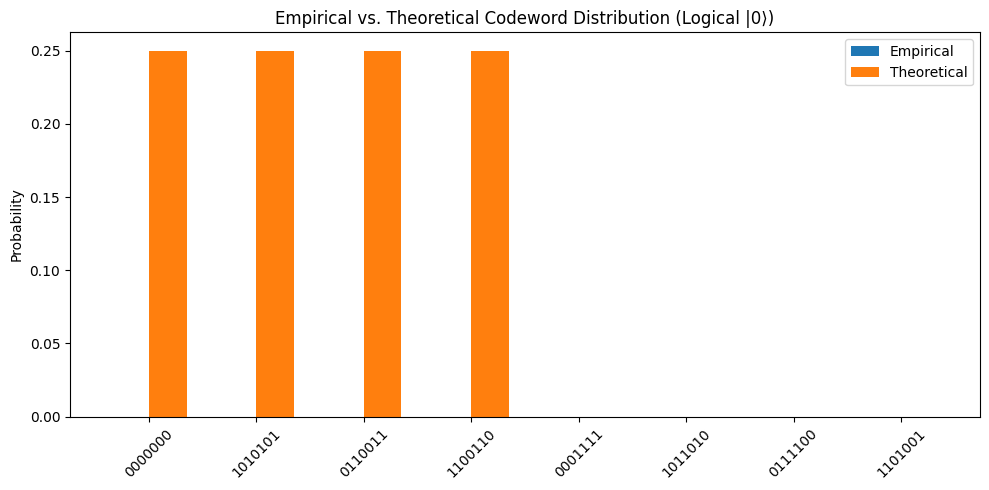

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer

# Initialize simulator using qiskit_aer
simulator = Aer.get_backend('aer_simulator')

# Number of simulation shots
num_shots = 200

# Build the Steane pipeline circuit with error probability p=0.3
steane_circuit = steane_full_pipeline(0.3)

# Transpile for the simulator backend
compiled_circuit = transpile(steane_circuit, simulator)

# Run the simulation
job = simulator.run(compiled_circuit, shots=num_shots)
result = job.result()

# Get measurement counts
counts = result.get_counts()

# Process results to compute empirical distribution over codewords
empirical_distribution = {}
for bitstring, count in counts.items():
    codeword = bitstring[:7]  # extract code qubit bits
    empirical_distribution[codeword] = empirical_distribution.get(codeword, 0) + count / num_shots

# Define your list of valid Steane codewords (standard [7,4,3] Hamming codewords)
valid_codewords = [
    "0000000", "1010101", "0110011", "1100110",
    "0001111", "1011010", "0111100", "1101001"
]

# Define theoretical distribution for logical |0⟩ encoded state (even-weight codewords)
even_weight_codewords = ["0000000", "1010101", "0110011", "1100110"]
theoretical_distribution = {cw: 1 / len(even_weight_codewords) if cw in even_weight_codewords else 0 for cw in valid_codewords}

# Compute total probability of valid codewords
total_valid_prob = sum([empirical_distribution.get(cw, 0) for cw in valid_codewords])

# Print results
print("Empirical distribution over codewords:")
for cw in valid_codewords:
    prob = empirical_distribution.get(cw, 0)
    print(f"{cw}: {prob:.4f}")

print("\nTotal probability of valid codewords:", total_valid_prob)

# --- Plot comparison ---
labels = valid_codewords
empirical_probs = [empirical_distribution.get(cw, 0) for cw in labels]
theoretical_probs = [theoretical_distribution.get(cw, 0) for cw in labels]

x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - bar_width/2, empirical_probs, bar_width, label='Empirical')
plt.bar(x + bar_width/2, theoretical_probs, bar_width, label='Theoretical')
plt.xticks(x, labels, rotation=45)
plt.ylabel('Probability')
plt.title('Empirical vs. Theoretical Codeword Distribution (Logical |0⟩)')
plt.legend()
plt.tight_layout()
plt.show()

This simulation runs the **full Steane code pipeline** with:

1. **Encoding:** Encodes the logical qubit using the Steane code.
2. **Pauli error injection:** Introduces a random single-qubit Pauli error with probability `p=0.3`.
3. **Syndrome extraction and correction:** Measures syndromes and applies appropriate corrections.
4. **Decoding:** Decodes the corrected code back to the logical qubit state.

The circuit is simulated over **200 shots** using Qiskit Aer to obtain the measurement outcomes of the code qubits.

what is this plot?

- **Empirical probabilities (blue bars):** Show the frequency (normalized) of observing each 7-bit codeword outcome from the simulation.
- **Theoretical probabilities (orange bars):** Show the expected ideal distribution of codewords based on the Steane code without noise (or computed analytically for the noise model).

The plot compares how closely the **empirical results** match the **theoretical expectations**, giving insight into:

- The effectiveness of the Steane code in correcting single-qubit errors.
- The fidelity of the recovered logical state after error correction.

A good quantum error correction implementation should produce an empirical distribution with **high probability mass concentrated on the valid codewords**, matching the theoretical distribution closely.